In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_turbulence_1d

In [2]:
seed = 1
N = 100
T = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  # 0.8

configs = {
    "p0": dict(riemann_solver="llf", p=0),
    "MUSCL-Hancock(minmod)": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="minmod",
        flux_recipe=2,
    ),
    "MUSCL-Hancock(moncen)": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        flux_recipe=2,
    ),
    # "ZS3": dict(
    #     riemann_solver="llf",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     ZS=True,
    #     PAD={"rho": (0, None)},
    # ),
    # "MM3": dict(
    #     riemann_solver="llf",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     MOOD=True,
    #     limiting_vars=("rho", "vx"),
    #     cascade="muscl",
    #     MUSCL_limiter="moncen",
    #     max_MOOD_iters=1,
    #     NAD=True,
    #     NAD_rtol=1e-2,
    #     NAD_atol=1e-8,
    #     PAD={"rho": (0, None)},
    # ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_turbulence_1d, seed=seed, M=10, h=1 / N),
        isothermal=True,
        nx=N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True)
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #112 @ t=9.07e-02 | dt=1.58e-03 | min(rho)=4.63e-02, min(P)=4.63e-02 | (done)                  
Running simulation: MUSCL-Hancock(minmod)
Step #123 @ t=9.06e-02 | dt=1.31e-03 | min(rho)=5.96e-02, min(P)=5.96e-02 | (done)                  
Running simulation: MUSCL-Hancock(moncen)
Step #124 @ t=9.00e-02 | dt=1.30e-03 | min(rho)=5.97e-02, min(P)=5.97e-02 | (done)                  


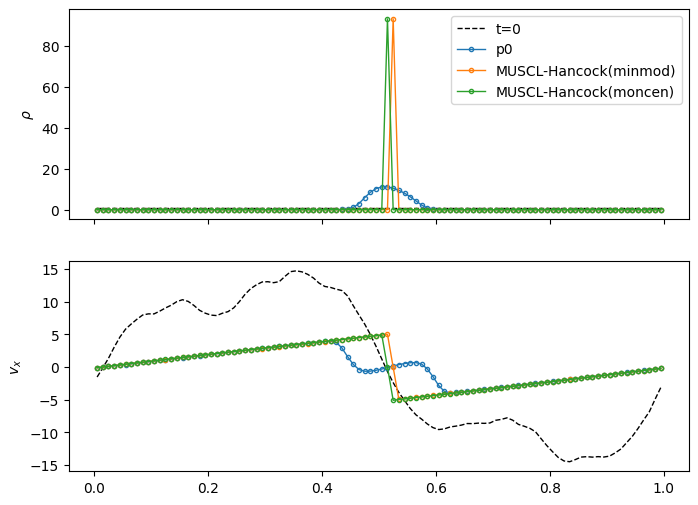

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

plot_1d_slice(sims[list(sims.keys())[0]], axs[0], "rho", t=0, label="t=0", **style0)
plot_1d_slice(sims[list(sims.keys())[0]], axs[1], "vx", t=0, label="t=0", **style0)

for name, sim in sims.items():
    plot_1d_slice(sim, axs[0], "rho", label=name, **style1)
    plot_1d_slice(sim, axs[1], "vx", label=name, **style1)
axs[0].legend()

/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0104671
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0104671
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0102869
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0102869
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0102407
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched i

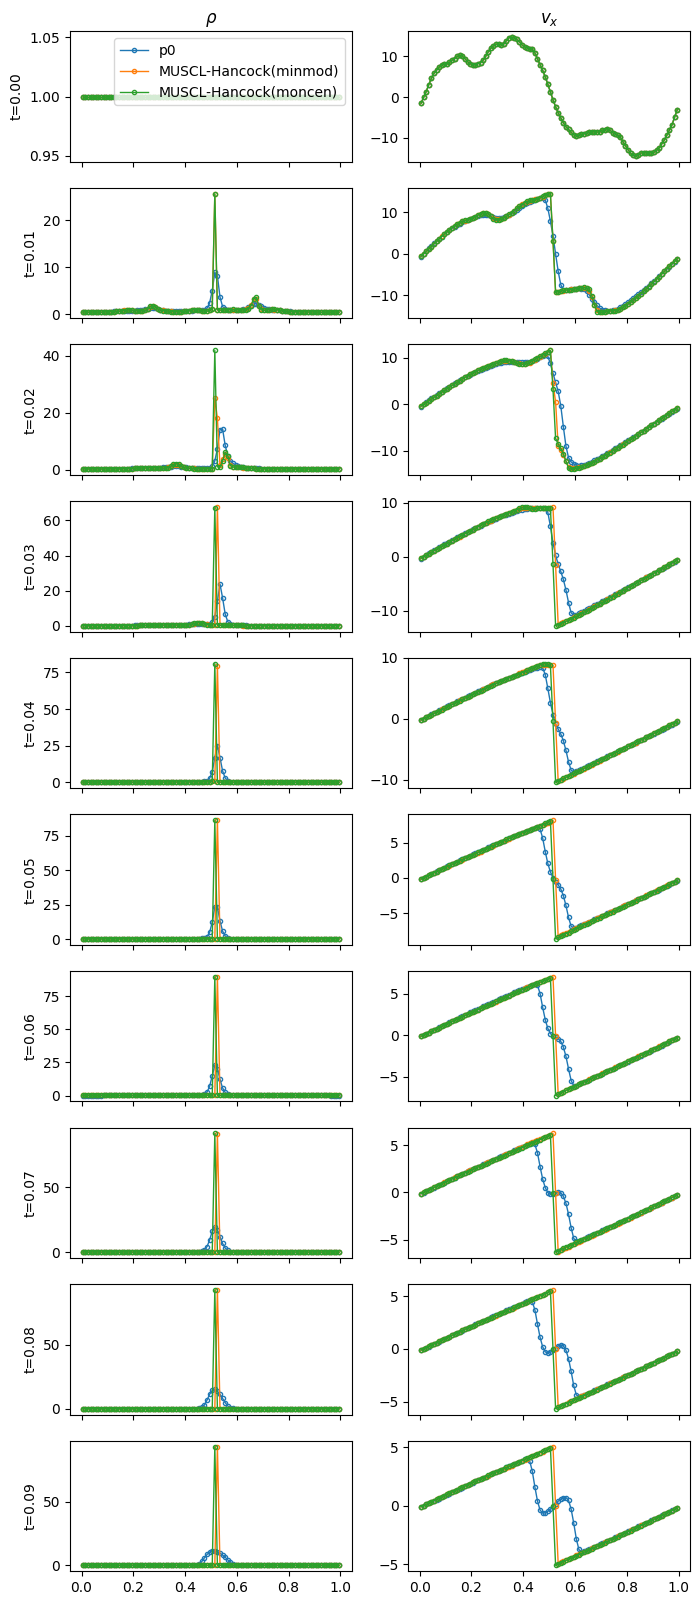

In [5]:
fig, axs = plt.subplots(10, 2, figsize=(8, 20), sharex=True)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v_x$")

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

tplot = 0.02
for i, tplot in enumerate([0] + T):
    for name, sim in sims.items():
        axs[i, 0].set_ylabel(f"t={tplot:.2f}")
        plot_1d_slice(sim, axs[i, 0], "rho", t=tplot, label=name, **style1)
        plot_1d_slice(sim, axs[i, 1], "vx", t=tplot, label=name, **style1)
axs[0, 0].legend()